<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка,-исследовательский-анализ-(EDA)-и-предобработка-данных" data-toc-modified-id="Загрузка,-исследовательский-анализ-(EDA)-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка, исследовательский анализ (EDA) и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Предварительная-обработка-обучающих-данных" data-toc-modified-id="Предварительная-обработка-обучающих-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Предварительная обработка обучающих данных</a></span></li></ul></li><li><span><a href="#Fine-tuning-модели" data-toc-modified-id="Fine-tuning-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fine-tuning модели</a></span></li><li><span><a href="#Оценка-модели" data-toc-modified-id="Оценка-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценка модели</a></span></li><li><span><a href="#Fine-tuning-модели-на-полных-обучающих-данных" data-toc-modified-id="Fine-tuning-модели-на-полных-обучающих-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fine-tuning модели на полных обучающих данных</a></span></li><li><span><a href="#Прогнозирование-и-формирование-результатов" data-toc-modified-id="Прогнозирование-и-формирование-результатов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Прогнозирование и формирование результатов</a></span></li><li><span><a href="#Проверка-на-тестовом-датасете" data-toc-modified-id="Проверка-на-тестовом-датасете-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка на тестовом датасете</a></span></li><li><span><a href="#Вывод-исследования" data-toc-modified-id="Вывод-исследования-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод исследования</a></span></li></ul></div>

# Извлечение текста из документа

В компании X работают с различными документами, такими как: арбитражные иски, госзакупки, исполнительные производства.

**Цель** — построить модель, которая поможет отделу госзакупок извлекать нужный кусок текста из документа для того, чтобы сформировать анкету заявки.

**Задача исследования** — разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста.

**Исследование пройдёт в семь этапов:**
 1. Загрузка, исследовательский анализ (EDA) и предобработка данных;
 2. Fine-tuning модели;
 3. Оценка модели;
 4. Fine-tuning модели на полных обучающих данных;
 5. Прогнозирование и формирование результатов;
 6. Проверка на тестовом датасете
 7. Вывод исследования.
 
*Примечания:* 
* Всего в каждом документе есть следующие пункты анкеты, по которым необходимо извлекать кусочки из текста:
    - обеспечение исполнения контракта;
    - обеспечение гарантийных обязательств.
* Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически требуемому фрагменту.

## Загрузка, исследовательский анализ (EDA) и предобработка данных

### Импорт библиотек

In [54]:
#!pip install datasets transformers

In [55]:
#pip install --upgrade accelerate

In [56]:
#!pip install evaluate

In [57]:
# импорт библиотек
import pandas as pd
import numpy as np
import random
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import transformers
import collections
import torch

from datasets import Dataset, concatenate_datasets, load_dataset, DatasetDict, ClassLabel, Sequence, load_metric
from IPython.display import display, HTML
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, default_data_collator

In [58]:
# сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

Данные для исследования получаем из файла `train`:

In [59]:
# чтение файлов с данными
datasets = load_dataset("json", data_files="train.json")

Found cached dataset json (C:/Users/m1kha/.cache/huggingface/datasets/json/default-4d9400708ee3ba2b/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'extracted_part'],
        num_rows: 1799
    })
})

### Описание данных

**Данные для обучения в формате json имеют следующие поля:**
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
    ```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
   ```

**Для демонстрации работы модели используются данные из файла `test.json`.**     
В нем есть все те же поля, что и в файле `train.json` (кроме целевого поля `extracted_part`).

In [61]:
datasets["train"][0]

{'id': 809436509,
 'text': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета

Ответы содержат начальную позицию (answer_start), конечную позицию (answer_end) и текст ответа (text), который является подстрокой документа.

### Исследовательский анализ данных (EDA)

Чтобы получить представление о том, как выглядят данные, отобразим несколько примеров, выбранных случайным образом в наборе данных, с помощью следующей функции:

In [62]:
def show_random_elements(dataset, num_examples=3):
    assert num_examples <= len(dataset), "Невозможно выбрать больше элементов, чем есть в наборе данных!"
    picks = [] #создаем список для наполнения случайными элементами
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [63]:
show_random_elements(datasets["train"])

,id,text,label,extracted_part
0,103865247,"ПРОЕКТ КОНТРАКТА №_____ на поставку товара г. ___________________ «___» _________ 20__ г. Государственное бюджетное учреждение здравоохранения Самарской области ''Отрадненская городская больница'', в лице Кандрахина Александра Анатольевича, действующего на основании Устава, тельств, ранее не обеспеченных предоставленным обеспечением исполнения контракта, поставщик предоставляет обеспечение исполнение контракта с учетом положений части 1.3 статьи 95 Федеральным законом от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд». 7.14. Исключение банка из перечня, предусмотренного частью 1.2 статьи 45 Закона № 44-ФЗ, региональной гарантийной организации из перечня, предусмотренного частью 1.7 статьи 45 Закона № 44-ФЗ, не прекращает действия выданных гарантом и принятых заказчиками независимых гарантий и не освобождает гаранта от ответственности за неисполнение либо ненадлежащее исполнение условий таких независимых гарантий. 8. ОБЕСПЕЧЕНИЕ ГАРАНТИЙНЫХ ОБЯЗАТЕЛЬСТВ 8.1. Обеспечение гарантийных обязательств предоставляется Поставщиком на любом этапе исполнения Контракта до оформления документа о приемке поставленного Товара (за исключением отдельного этапа исполнения контракта). 8.2. Обеспечение гарантийных обязательств устанавливается в размере 6 159,00 рублей. Гарантийное обязательство представляется на срок не менее 12 месяцев. 8.3. Гарантийные обязательства обеспечиваются предоставлением независимой гарантии, выданной организацией, указанной в части 1 статьи 45 Федерального закона «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд» и соответствующей требованиям статьи 45 Закона № 44-ФЗ, или внесением денежных средств на указанный Заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими Заказчику. Способ обеспечения гарантийных обязательств, срок действия независимой гарантии определяются в соответствии с требованиями Закона № 44-ФЗ участником закупки, с которым заключается контракт, самостоятельно. Срок действия независимой гарантии должен превышать предусмотренный Контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со статьей 95 Закона № 44-ФЗ. Заказчик: Наименование: Государственное бюджетное учреждение здравоохранения Самарской области ''Отрадненская городская больница'' Место нахождения: Российская Федерация, 446302, Самарская обл, Отрадный г, УЛИЦА ЛЕНИНА, ---, 61/--- Почтовый адрес: Российская Федерация, 446302, Самарская",обеспечение гарантийных обязательств,"{'answer_end': [1424], 'answer_start': [1275], 'text': ['Обеспечение гарантийных обязательств устанавливается в размере 6 159,00 рублей. Гарантийное обязательство представляется на срок не менее 12 месяцев.']}"
1,452686280,"Приложение 3 Проект Государственный контракт на оказание услуг № __________ г. Минусинск «____» ____________ 2022 г. федеральное казенное учреждение «Тюрьма Главного управления Федеральной службы исполнения наказаний по Красноярскому краю» (сокращенное тв по контракту. 6.14. Вред, причиненный третьим лицам по вине Поставщика при исполнении обязательств по контракту, возмещается за его счет. 7. Обеспечение исполнения Контракта 7.1. Настоящий Контракт заключается после предоставления Исполнителем документа, подтверждающего предоставление обеспечения Контракта Государственному заказчику. 7.2. В целях обеспечения исполнения обязательств Исполнителя по настоящему Контракту Исполнитель предоставляет Государственному заказчику безотзывную независимую гарантию или вносит денежные средства на указанный Государственным заказчиком счет, на котором в соответствии с законодательством РФ учитываются операции со средствами, поступающими Государственному заказчику. Независимая гарант

Оценим долю поисковых запросов каждого вида в исходном датасете:

In [64]:
datasets["train"]["label"].count('обеспечение исполнения контракта')/len(datasets["train"])

0.5491939966648138

In [65]:
datasets["train"]["label"].count('обеспечение гарантийных обязательств')/len(datasets["train"])

0.4508060033351862

Значения поисковых запросов (название пункта анкеты) представлены в наборе данных достаточно равномерно.

Найдем максимальную длину ответа в символах и в словах:

In [66]:
string  = ['']
string_length = []
for i,  context in enumerate(datasets['train']['extracted_part']):
    string_length.append(len(context['text'][0]))
    if len(context['text'][0]) >  len(string[0]):
        string[0] = context['text'][0]
print(string)
print("Максимальная длина ответа (символов):", len(string[0]))

['Требования к независимым гарантиям, предоставляемые в качестве обеспечения заявок, гарантийных обязательств и исполнения Договора Обеспечение исполнения Договора требуется в размере 10% (Десять) процентов от цены, по которой в соответствии с Федеральным законом № 44-ФЗ заключается Договор. В случае ес']
Максимальная длина ответа (символов): 302


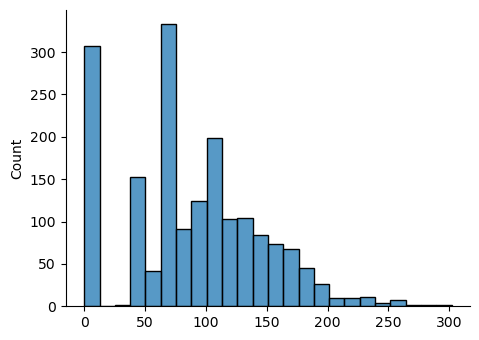

In [67]:
# распределение длины ответов в символах
sns.displot(string_length, height=3.5, aspect=1.4);

In [68]:
words  = ''
words_length = []
for i,  context in enumerate(datasets['train']['extracted_part']):
    words_length.append(len(context['text'][0].split(' ')))
    if len(context['text'][0].split(' ')) >  len(words):
        words = context['text'][0].split(' ')
print(words)
print("Максимальная длина ответа (слов):", len(words))

['Подрядчик', 'в', 'срок', 'до', '10', '(десяти)', 'рабочих', 'дней', 'предоставляет', 'Заказчику', 'обеспечение', 'гарантийных', 'обязательств', 'в', 'соответствии', 'с', 'частью', '2.2', 'статьи', '96', 'Закона', 'о', 'контрактной', 'системе', 'в', 'размере', '1', 'процент', 'начальной', '(максимальной)', 'цены', 'контракта/цены', 'контракта,', 'что', 'составляет', '62', '577', 'рублей', '00', 'копеек.']
Максимальная длина ответа (слов): 40


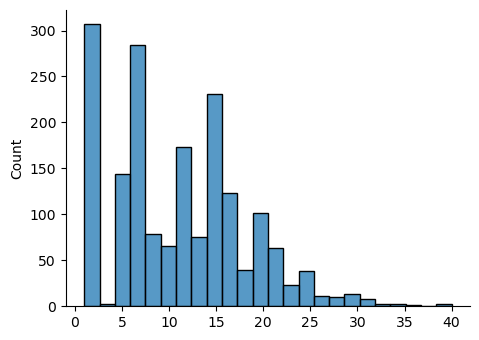

In [69]:
# распределение длины ответов в словах
sns.displot(words_length, height=3.5, aspect=1.4);

### Предварительная обработка обучающих данных

In [70]:
# установка параметров
model_checkpoint = "DeepPavlov/rubert-base-cased"
batch_size = 20 # размер батча
max_length = 384 # максимальная длина поддокумента (вопрос и документ)
doc_stride = 128 # допустимое перекрытие (overlap) между двумя частями документа при его разделении

Загрузим токенизатор:

In [71]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# проверочное утверждение, что наш токенизатор является быстрым токенизатором из библиотеки HuggingFace Tokenizers.
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [72]:
pad_on_right = tokenizer.padding_side == "right" # по умолчанию паддинг справа

Составим список id документов которые содержат ответ на поисковый запрос:

In [73]:
not_missing_values = []
for i,  context in enumerate(datasets['train']['extracted_part']):
    if context['text'] != ['']:
        not_missing_values.append(datasets['train']['id'][i])
print(len(not_missing_values))

1492


In [74]:
# фильтруем датасет — избавляемся от пустых ответов
datasets = datasets.filter(lambda x: x['id'] in not_missing_values)

Filter:   0%|          | 0/1799 [00:00<?, ? examples/s]

In [75]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'extracted_part'],
        num_rows: 1492
    })
})

В датасете осталось 1492 строки, мы удалили 17% данных не содержащих ответ на поисковый запрос и бесполезных для дообучения модели.

Создадим функцию, которая поможет нам стратифицировать выборку:

In [76]:
def stratification(dataset):
    stratified_list = []
    for context in dataset:
        if context['label'] == 'обеспечение гарантийных обязательств':
            stratified_list.append(1)
        else:
            stratified_list.append(0)

    stratified_series = pd.Series(stratified_list)
    
    train_indices, test_indices = train_test_split(stratified_series, test_size=0.2, stratify=stratified_series,
                                                   shuffle=True, random_state=42)
    return dataset.select(train_indices.index), dataset.select(test_indices.index)

Cформируем обучающую и валидационную выборки в соотношении 80/20:

In [77]:
train, valid = stratification(datasets["train"])
datasets_train_valid = DatasetDict({
    "train": train,
    "valid": valid
})
datasets_train_valid

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'extracted_part'],
        num_rows: 1193
    })
    valid: Dataset({
        features: ['id', 'text', 'label', 'extracted_part'],
        num_rows: 299
    })
})

Следующая функция обработает обучающий датасет. В случае ненайденных ответов (ответ находится в другом поддокументе, ответа нет в документе) мы установим индекс `[CLS]` для начальной и для конечной позиции.

In [78]:
def prepare_features(examples):
    # Избавимся от пробелов, если они есть в запросах
    examples["label"] = [q.lstrip() for q in examples["label"]]

    # Токенизируем примеры с помощью усечения (truncation) и заполнения (padding),
    # оставим перекрытие (overflows) с помощью шага (stride).
    # Это приведет разделению длинного документа на нескольких поддокументов,
    # каждый из которых содержит текст, частично перекрывающий текст предыдущего поддокумента.
    tokenized_examples = tokenizer(
        examples["label" if pad_on_right else "text"], # учитываем возможность смены порядка вопроса и документа
        examples["text" if pad_on_right else "label"],
        truncation="only_second" if pad_on_right else "only_first", #усечение по "text", но не "label" 
        max_length=max_length, # максимальная длина признака
        stride=doc_stride, # шаг перекрытия
        return_overflowing_tokens=True, # разделение длинных текстов на отдельные поддокументы
        return_offsets_mapping=True, # возвращаем нач. и конечную позиции для каждого токена
        padding="max_length", # заполнение special padding token коротких признаков до максимальной длины
    )

    # Так как один длинный документ может дать нам несколько поддокументов, нам нужна карта поддокументов сопоставленных
    # соответствующему документу. overflow_to_sample_mapping указывает, какая часть токенизированного текста
    # относится к какому документу.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # offset_mapping даст нам карту положений токенов в исходном документе. Это поможет вычислить start_positions 
    # и end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Списки для размеченных примеров
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping): # посчитаем кол-во итераций с помощью enumerate (i - счетчик)
        # Мы будем помечать невозможные ответы индексом токена CLS.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Последовательность положений токенов (какие именно соответствуют вопросу, а какие — документу).
        sequence_ids = tokenized_examples.sequence_ids(i)
        
        # Индекс поддокумента, содержащего фрагмент текста.
        sample_index = sample_mapping[i]
        answers = examples["extracted_part"][sample_index]
        # Если ответов нет, установить cls_index в качестве ответа.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Индекс начала/конца символа ответа в тексте.
            start_char = answers["answer_start"][0]
            end_char = answers["answer_end"][0]

            # Индекс начального токена текущего поддокумента в тексте.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # Индекс конечного токена текущего поддокумента.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Определить, выходит ли ответ за диапазон (в этом случае этот признак помечается индексом CLS).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # В противном случае переместим token_start_index и token_end_index на начало и конец токенов ответа.
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

Используем метод `map` применив эту функцию ко всем документам в наборе данных:

In [79]:
tokenized_datasets_train_valid = datasets_train_valid.map(prepare_features, batched=True, load_from_cache_file=True,
                                  remove_columns=datasets_train_valid["train"].column_names)

Map:   0%|          | 0/1193 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

In [80]:
tokenized_datasets_train_valid

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 2445
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 611
    })
})

Проверим работу функции на первом примере из датасета:

In [81]:
datasets_train_valid["train"][0]

{'id': 59215382,
 'text': 'Приложение № 5 к извещению об электронном конкурсе УТВЕРЖДАЮ Начальник управления строительства объектов инженерно-транспортного обеспечения, социальных и жилищных объектов СПб ГКУ «ФКСР» ________________ А.А. Авениров «__» ___________ 2022г. оронами дополнительно, Подрядчик обязуется устранить выявленные недостатки (дефекты) работ не позднее 1 (одного) месяца со дня получения требования от Заказчика. 6.9. В случае отказа Подрядчика от устранения выявленных недостатков (дефектов) работ или в случае неустранения недостатков (дефектов) работ в установленный срок Заказчик вправе привлечь третьих лиц с возмещением расходов на устранение недостатков (дефектов) работ за счет Подрядчика. 6.10. Течение гарантийного срока прерывается на все время, на протяжении которого объект не мог эксплуатироваться вследствие недостатков (дефектов) работ, за которые отвечает подрядчик. 6.11. На время выполнения Подрядчиком своих гарантийных обязательств Подрядчик по требованию Зака

In [82]:
for x in tokenized_datasets_train_valid["train"]["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] обеспечение гарантийных обязательств [SEP] Приложение № 5 к извещению об электронном конкурсе УТВЕРЖДАЮ Начальник управления строительства объектов инженерно - транспортного обеспечения, социальных и жилищных объектов СПб ГКУ « ФКСР » _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ А. А. Авениров « _ _ » _ _ _ _ _ _ _ _ _ _ _ 2022г. оронами дополнительно, Подрядчик обязуется устранить выявленные недостатки ( дефекты ) работ не позднее 1 ( одного ) месяца со дня получения требования от Заказчика. 6. 9. В случае отказа Подрядчика от устранения выявленных недостатков ( дефектов ) работ или в случае неустранения недостатков ( дефектов ) работ в установленный срок Заказчик вправе привлечь третьих лиц с возмещением расходов на устранение недостатков ( дефектов ) работ за счет Подрядчика. 6. 10. Течение гарантийного срока прерывается на все время, на протяжении которого объект не мог эксплуатироваться вследствие недостатков ( дефектов ) работ, за которые отвечает подрядчик. 6. 11. На время выполнения П

Функция разбила длинный документ на 2 поддокумента меньшего размера. Последний поддокумент дозаполнен с помощью паддинга до 384 токенов.

## Fine-tuning модели

In [ ]:
# Загрузим предварительно обученную модель и настроим её.
# Поскольку задачей является поиск ответа на запрос в документе мы будем использовать модель
# класса AutoModelForQuestionAnswering.

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

# Зададим параметры обучения - TrainingArguments:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0,
    load_best_model_at_end=True
)

# Нам потребуется сборщик данных, который будет объединять наши обработанные примеры в батчи:
data_collator = default_data_collator

# Передадим теперь всё это вместе с нашими наборами данных в класс Trainer:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets_train_valid["train"],
    eval_dataset=tokenized_datasets_train_valid["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Выполняем обучение
trainer.train()

# Сохраняем модель и Trainer:
trainer.save_model('QA_trainer_save_pretrained')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from 

Epoch,Training Loss,Validation Loss
1,No log,0.677983
2,No log,0.499132
3,No log,0.450568
4,No log,0.426904
5,0.619300,0.439582


## Оценка модели

Возьмем батч из нашего валидационного хранилища данных - результатом модели является объект, который содержит потери, начальный и конечный логиты:

In [ ]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

Посмотрим на логиты:

In [ ]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([20, 384]), torch.Size([20, 384]))

In [ ]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([174,   0, 322,  73, 281,  31, 245,   0, 271,  22, 110,   0,   0, 250,
           0, 293,  43, 268,   0, 247], device='cuda:0'),
 tensor([193,   0, 340, 111, 307,  57, 254,   0, 298,  36,   0,   0,   0, 260,
           0, 306,  56, 297,   0, 268], device='cuda:0'))

Подоготовим валидационные данные — добавим к функции проверки идентификатор примера (для сопоставления поддокументов с документами) и mapping (карту индексов токенов в тексте).
Повторно обработаем проверочный набор следующей функцией, немного отличающейся от prepare_features:

In [ ]:
def prepare_valid_features(examples):
    # Избавимся от пробелов, если они есть в запросах
    examples["label"] = [q.lstrip() for q in examples["label"]]

    # Токенизируем примеры с помощью усечения (truncation) и заполнения (padding),
    # но оставим перекрытие (overflows) с помощью шага (stride).
    # Это приводит к нескольким признакам, когда документ слишком длинный,
    # каждый из признаков содержит текст, который перекрывает текст предыдущей функции.
    tokenized_examples = tokenizer(
        examples["label" if pad_on_right else "text"], # учитываем возможность смены порядка вопроса и документа
        examples["text" if pad_on_right else "label"], 
        truncation="only_second" if pad_on_right else "only_first", #усечение по "text", но не "label" 
        max_length=max_length, # максимальная длина признака
        stride=doc_stride, # шаг перекрытия
        return_overflowing_tokens=True, # разделение длинных текстов на отдельные признаки
        return_offsets_mapping=True, # возвращаем нач. и конечную позиции для каждого токена
        padding="max_length" # заполнение special padding token коротких признаков до максимальной длины
    )

    # Так как один длинный документ может дать нам несколько подтекстов, нам нужна карта подтекстов сопоставленных
    # соответствующему документу. overflow_to_sample_mapping указывает, какая часть токенизированного текста
    # относится к какому документу.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # Сохраняем example_id для соответствующего признака
    tokenized_examples["example_id"] = []
    
    for i in range(len(tokenized_examples["input_ids"])):
        # Последовательность положений токенов (какие именно соответствуют вопросу, а какие — документу).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # Один документ может дать несколько поддокументов. Это индекс документа, содержащего этот фрагмент текста.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Установить значение None для токенов из offset_mapping, которые не являются частью текста.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

Применим эту функцию к нашему валидационному набору данных:

In [ ]:
validation_features = datasets_train_valid["valid"].map(
    prepare_valid_features,
    batched=True,
    remove_columns=datasets_train_valid["valid"].column_names
)

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

In [ ]:
validation_features

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 611
})

Получим прогнозы с помощью метода Trainer.predict:

In [ ]:
raw_predictions = trainer.predict(validation_features)

In [ ]:
raw_predictions

PredictionOutput(predictions=(array([[-5.158085 , -4.1063795, -5.7692013, ..., -7.052296 , -6.917901 ,
        -4.0569634],
       [ 6.326401 , -4.085205 , -5.934352 , ..., -7.056402 , -7.0510836,
        -7.038477 ],
       [-3.7348342, -4.32193  , -5.611331 , ..., -7.1036625, -6.95242  ,
        -4.368887 ],
       ...,
       [ 6.17198  , -4.2812366, -5.88287  , ..., -6.9870386, -6.973735 ,
        -6.9653788],
       [-5.572543 , -4.6525936, -5.8140306, ..., -7.1919684, -7.0974197,
        -4.1843657],
       [ 6.243964 , -4.7478867, -5.8705034, ..., -6.8377924, -6.7866173,
        -6.8465767]], dtype=float32), array([[-6.054068 , -6.4516077, -6.3165073, ..., -6.7900615, -7.03708  ,
        -3.8426719],
       [ 7.114487 , -5.9934826, -6.313772 , ..., -6.9599037, -6.9889107,
        -7.058507 ],
       [-4.6665277, -5.921934 , -6.032112 , ..., -6.222867 , -6.1915417,
        -4.253269 ],
       ...,
       [ 6.740321 , -5.6793237, -6.1452193, ..., -7.1928473, -7.1915646,
        -7

Вернем скрытые столбцы example_id и offset_mapping:

In [ ]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

Для классификации наших ответов мы будем использовать оценку, полученную путем сложения начальных и конечных значений логитов. Ограничим количество ответов гиперпараметром n_best_size — выберем лучшие индексы в начальных и конечных значениях логитов и соберем все ответы, которые они предсказывают. После проверки каждого из них на допустимость, мы отранжируем их и оставим лучший.

Создадим функцию постобработки:

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 30, max_answer_length = 60):
    all_start_logits, all_end_logits = raw_predictions
    
    # Создаем карту для соответствующих подтекстов.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])} # id: index
    features_per_example = collections.defaultdict(list) # пустой словарь    
    # наполняем словарь данными вида: порядковый индекс документа: [номера поддокументов соответствующих документу]
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # Словарь для заполнения:
    predictions = collections.OrderedDict()

    print(f"Постобработка {len(examples)} текстов разбитых на {len(features)} подтекстов.")

    # Цикл по всем текстам
    for example_index, example in enumerate(tqdm(examples)):
        # Индексы подтекстов, связанных с текущим текстом.
        feature_indices = features_per_example[example_index]

        valid_answers = []
        
        context = example["text"]
        
        # Перебор всех подтекстов, связанных с текущим текстом.
        for feature_index in feature_indices:
            
            # Возьмем предсказания модели для этих текстов:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            
            # mapping позволит сопоставить позиции логитов с диапазоном подтекстов оригинального текста
            offset_mapping = features[feature_index]["offset_mapping"]

            # Соберем индексы лучших начальных/конечных логитов:
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Не учитываем нестандартные ответы, индексы которых выходят за пределы границ
                    # или ответы, соответствущие частям input_ids которых нет в тексте
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                   # Не учитываем ответы, с нулевой длиной или длиной больше max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "answer_end": [end_char],
                            "answer_start": [start_char],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # В очень редком пограничном случае, когда у нас нет ни одного ненулевого предсказания, 
            # мы создаем ложный прогноз, чтобы избежать ошибки.
            best_answer = {"text": "", "score": 0.0}
        
        # Выберем окончательный ответ: лучший или нулевой ответ:
        predictions[example["id"]] = {"answer_end": best_answer["answer_end"],
                                      "answer_start": best_answer["answer_start"],
                                      "text": [best_answer["text"]]} if best_answer["score"] > 0 else {"answer_end": [], "answer_start": [], "text": [""]}
        
    return predictions

Применим функцию постобработки к нашим необработанным прогнозам:

In [ ]:
final_predictions = postprocess_qa_predictions(datasets_train_valid["valid"], validation_features, raw_predictions.predictions)

Постобработка 299 текстов разбитых на 611 подтекстов.


  0%|          | 0/299 [00:00<?, ?it/s]

Отформатируем полученные прогнозы и референсные данные, чтобы использовать из для расчета метрики:

In [ ]:
# прогнозы
formatted_predictions = [{"id": k, 
                          "answer_end": v["answer_end"],
                          "answer_start": v["answer_start"],
                          "text": v["text"]
                         } for k, v in final_predictions.items()]

# валидационные значения
references = [{"id": ex["id"], 
               "answer_end": ex["extracted_part"]["answer_end"],
               "answer_start": ex["extracted_part"]["answer_start"],
               "text": ex["extracted_part"]["text"]               
               } for i,ex in enumerate(datasets_train_valid["valid"])]

Сравним прогноз с ответом в валидационной выборке:

In [ ]:
compare = pd.DataFrame(datasets_train_valid["valid"])
compare["answers"] = formatted_predictions
compare.head(1)

,text,id,label,extracted_part,answers
0,"Раздел 3. или дающие основание предполагать, что произошло или может произойти нарушение каких-либо положений настоящих условий контрагентом, его аффилированными лицами, работниками или посредниками, выражающееся в действиях, квалифицируемых применимым законодательством, как дача или получение взятки, коммерческий подкуп, а также действиях, нарушающих требования применимого законодательства и международных актов о противодействии легализации доходов, полученных преступным путем. 14 Обеспечение исполнения договора 14.1. Обеспечение исполнения Договора может быть предоставлено участником закупки путем перечисления денежных средств на указанный заказчиком счет или предоставления независимой гарантии, выданной банком. 14.2. Должны быть обеспечены обязательства Поставщика по возмещению убытков Заказчика, причиненных неисполнением или ненадлежащим исполнением обязательств по Договору, а также обязанность по выплате неустойки (штрафа, пени) и иных долгов, возникших у Поставщика перед Заказчиком. 14.3. Обеспечение исполнения Договора, предоставляется на сумму 5 % от начальной максимальной цены Договора/максимального значения цены договора, что составляет 13 398 рублей 00 копеек. Если в ходе проведения конкурентной закупки при заключении Договора победителем закупки была снижена начальная максимальная цена Договора/начальная сумма цен единиц товара, работы, услуги на двадцать пять и более процентов, Заказчик применяет к победителю закупки антидемпинговые меры: победитель закупки обязан до заключения Договора предоставить обеспечение исполнения договора в размере, превышающем в полтора раза размер обеспечения исполнения Договора, указанный в извещении и (или) в документации о закупке. 14.4. Факт передачи денежных средств в обеспечение исполнения Договора подтверждается зачислением денежных средств на счет Заказчика. В случае, если участник закупки, с которым заключается Договор, вместе с таким Договором представил документ, подтверждающий внесение денежных средств в качестве обеспечения исполнения Договора, и такие денежные средства не поступили на счет Заказчика, указанный в закупочн Требования к качеству, техническим характеристикам товара, требования к их безопасности, к функциональным характеристикам (потребительским свойствам) товара, требования к размерам, упаковке, отгрузке товара, и иные показатели, связанные с определением соответствия поставляемого",439291516,обеспечение исполнения контракта,"{'answer_end': [1111], 'answer_start': [1010], 'text': ['Обеспечение исполнения Договора, предоставляется на сумму 5 % от начальной максимальной цены Договора']}","{'id': 439291516, 'answer_end': [1148], 'answer_start': [1010], 'text': ['Обеспечение исполнения Договора, предоставляется на сумму 5 % от начальной максимальной цены Договора/максимального значения цены договора']}"


Посчитаем Accuracy модели:

In [ ]:
predictions_list = []
for i, x in enumerate(references):
    for j, y in enumerate(formatted_predictions):
        if x["id"] == y["id"]:
            if x["text"][0] == y["text"][0]:
                predictions_list.append(1)
            else: 
                predictions_list.append(0)

In [ ]:
accuracy_metric = evaluate.load("accuracy")
results = accuracy_metric.compute(references=[1] * len(references), predictions=predictions_list)
results

{'accuracy': 0.7658862876254181}

## Fine-tuning модели на полных обучающих данных

In [ ]:
tokenized_datasets = datasets.map(prepare_features, batched=True, load_from_cache_file=True,
                                  remove_columns=datasets_train_valid["train"].column_names)

Map:   0%|          | 0/1492 [00:00<?, ? examples/s]

In [ ]:
# Загрузка ранее сохраненной настроенной модели
model = AutoModelForQuestionAnswering.from_pretrained('QA_trainer_save_pretrained')

# Зададим параметры обучения - TrainingArguments:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned_final_model",
    save_strategy = "no",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0,
    load_best_model_at_end=True
)

data_collator = default_data_collator

# Передадим теперь всё это вместе с нашими наборами данных в класс Trainer:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Выполняем обучение
trainer.train()

# Сохраняем модель и Trainer:
trainer.save_model('QA_trainer_save_pretrained')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.180000


## Прогнозирование и формирование результатов

In [ ]:
# чтение файлов с данными
datasets_test = load_dataset("json", data_files="test.json")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-b3aed09a11797876/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
datasets_test

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'label'],
        num_rows: 318
    })
})

In [ ]:
# предобработка тестовых данных
test_features = datasets_test["train"].map(
    prepare_valid_features,
    batched=True,
    remove_columns=datasets_test["train"].column_names
)

Map:   0%|          | 0/318 [00:00<?, ? examples/s]

In [ ]:
test_features

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 622
})

In [ ]:
# Формируем прогнозы
test_predictions = trainer.predict(test_features)

In [ ]:
# Вернем скрытые столбцы
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

In [ ]:
# Применим функцию постобработки к нашим необработанным прогнозам:
final_predictions_test = postprocess_qa_predictions(datasets_test["train"], test_features, test_predictions.predictions)

Постобработка 318 текстов разбитых на 622 подтекстов.


  0%|          | 0/318 [00:00<?, ?it/s]

In [ ]:
# Отформатируем полученные прогнозы и референсные данные, чтобы использовать из для расчета метрики:
formatted_predictions_test = [{"text": v["text"],
                               "answer_start": v["answer_start"],
                               "answer_end": v["answer_end"]
                              } for k, v in final_predictions_test.items()]

In [ ]:
compare_test = pd.DataFrame(datasets_test["train"])
compare_test["extracted_part"] = formatted_predictions_test
compare_test.head(1)

,text,id,label,extracted_part
0,"МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г. (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд» участником закупки, с которым заключается контракт, самостоятельно. 6.2. Обеспечение исполнения Контракта предоставляется Заказчику до заключения Контракта. Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта). Получатель: Комитет по финансам администрации Ханты-Мансийского района (Администрация Ханты-Мансийского района, л/сч 040.01.001.2) ИНН 8618002968 КПП 860101001 Банк плательщика: РКЦ Ханты-Мансийск//УФК по Ханты-Мансийскому автономному округу – Югре г. Ханты-Мансийск, ЕКС 40102810245370000007 БИК 007162163 Казначейский счет 03232643718290008700 В случае заключения контракта по результатам определения Исполнителя в соответствии с пунктом 1 части 1 статьи 30 Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд» размер обеспечения исполнения контракта, в том числе предоставляемого с учетом положений статьи 37 Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», устанавливается от цены, по которой в соответствии с Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере 13.Адреса места нахождения, банковские реквизиты и подписи Сторон ЗАКАЗЧИК: Администрация Ханты-Мансийского района Юридический адрес: 628011, Тюменская область, Ханты-Мансийский автономный округ - Югра, г. Ханты-Мансийск, ул. Гагарина, 214 Почтовый адрес: 628011,",762883279,обеспечение исполнения контракта,"{'text': ['Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'], 'answer_start': [1283], 'answer_end': [1393]}"


In [ ]:
empty_extracted = 0
for i in compare_test["extracted_part"]:
    if i['text'][0] == '':
        empty_extracted += 1
print("Отсутствует фрагментов к извлечению:", empty_extracted)
print("Доля отсутствующих фрагментов к извлечению:", round(empty_extracted/len(compare_test), 2))

Отсутствует фрагментов к извлечению: 54
Доля отсутствующих фрагментов к извлечению: 0.17


Сформируем итоговый файл с прогнозом:

In [ ]:
ds_test_predictions = DatasetDict({'train': Dataset.from_dict({'id': datasets_test["train"]["id"], 
                                                               'text': datasets_test["train"]["text"],
                                                               'label': datasets_test["train"]["label"],
                                                               'extracted_part': formatted_predictions_test})
                                  })

In [ ]:
for split, dataset in ds_test_predictions.items():
    dataset.to_json("predictions.json", force_ascii=False, orient='records', indent=2, lines=False)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Проверка на тестовом датасете

In [3]:
answers_test = load_dataset("json", data_files="test_with_labels.json")
answers_predictions = load_dataset("json", data_files="predictions.json")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-934430baca6be6fe/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-01be44909b89e318/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
predictions_list = []
for i, x in enumerate(answers_test["train"]):
    for j, y in enumerate(answers_predictions["train"]):
        if x["id"] == y["id"]:
            if x["extracted_part"]["text"] == y["extracted_part"]["text"]:
                predictions_list.append(1)
            else: 
                predictions_list.append(0)

In [5]:
accuracy_metric = evaluate.load("accuracy")
results = accuracy_metric.compute(references=[1] * len(answers_test["train"]), predictions=predictions_list)
results

{'accuracy': 0.8270440251572327}

## Вывод исследования

В ходе работы было выполнено:

* Загружены данные;
* Проведен исследовательский анализ данных;
* Выполнен Fine-tuning модели из DeepPavlov/rubert-base-cased и проведена преварительная оценка модели на валидационных данных;
* Дообучение модели на полном датасете;
* Прогнозирование на тестовых данных и формирование результатов;
* Проведена оценка модели: точность модели (Accuracy) на тестовых данных составила 0.8270.

**Таким образом, была разработана модель, которая способна по паре текст документа и пункт анкеты извлекать из текста документа нужный фрагмент.**

Рекомендации для дальнейшего исследования:
* Обучить и протестировать различные модели.
* Выполнить подбор оптимальных гиперпараметров.